In [3]:
from thesis_toolbox.utils import get_locations_CLP
import matplotlib as mpl
import xarray as xr
import matplotlib.pyplot as plt
from thesis_toolbox.plot.tools import add_letter
import glob
import seaborn as sns
import pandas as pd

In [10]:
if 'snakemake' in globals():
    to_file = True
    path=snakemake.config['old_base']+'/'
    files = snakemake.input.trajec_files
else:
    path ='../../../../../data/data/results/'
    to_file= False
    files=glob.glob(path+'model_results/trajectories/*wetdep*.nc')

In [12]:
rm_list = ['dust_loading_traj_wetdep_20micron_ULANTATAL', 'dust_loading_traj_wetdep_2micron_ULANTATAL']
locs_df = get_locations_CLP().drop('YINCHUAN')
locs = ['SHAPOTOU','SACOL','BAODE','LUOCHUAN','LINGTAI','LANTIAN']

scale_dep = 10800
dsets={}
dfs=[]
for site in locs:
    for ncfile in files:
        temp_file = xr.open_dataset(ncfile).isel(btime=0)
        temp_file = temp_file.drop(['btime','lons','lats'])
        key = ncfile.split('/')[-1].split('_')[:6]
        # print(key)
        
        if key[-1] == site:
            psize = key[4]
            key = '_'.join(key)
            temp_df = temp_file.to_dataframe()
            temp_df['wetdep'] = temp_df['wetdep']/scale_dep
            temp_df['site'] = site
            temp_df['psize'] = psize
            dsets[key]=temp_df
            dfs.append(temp_df)
for key in rm_list:
    dsets.pop(key, None)

In [13]:
df = pd.concat(dfs)

In [17]:
def plot_wetdep_height(ax,df,cmap,norm, cloud_base=2500):
    ax.axhline(y=cloud_base, color = 'k', linestyle=':')
    m = ax.scatter(x=df.index, y=df['height'], c=df['wetdep'], norm=norm, s=3, cmap=cmap,)


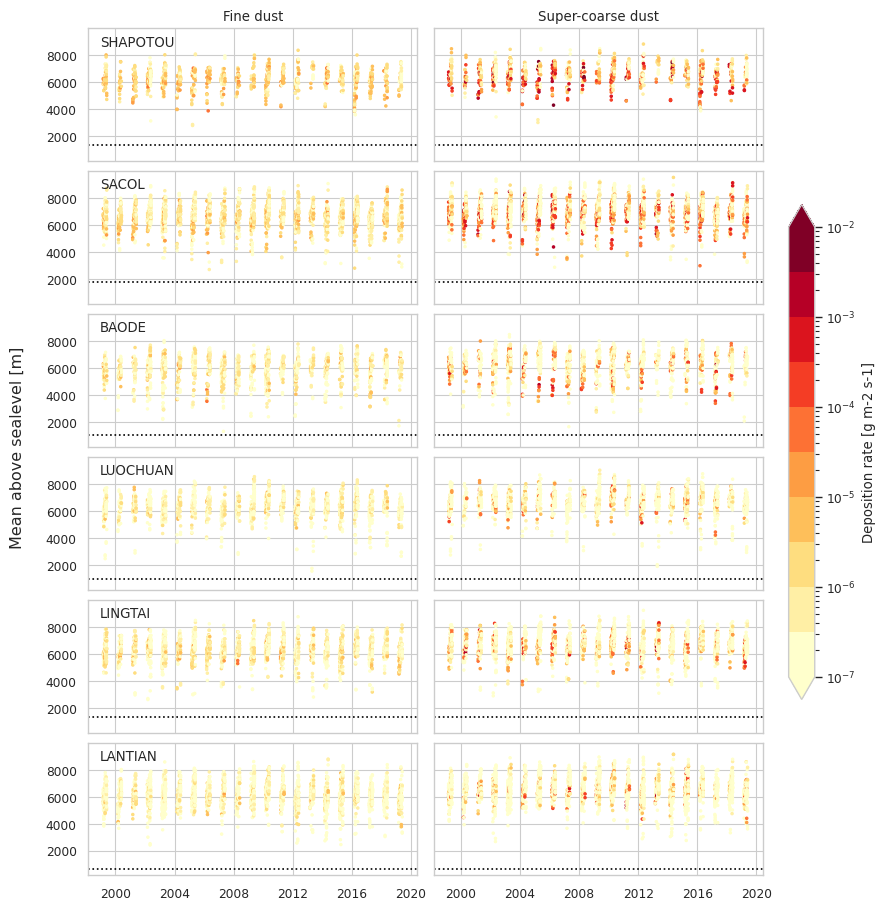

In [19]:
cmap = mpl.cm.YlOrRd.resampled(10)
nsites = len(locs)
norm = mpl.colors.LogNorm(vmin=1e-7, vmax=1e-2)
# norm = mpl.colors.BoundaryNorm([1e-6,1e-5,2.5e-5,5e-5,7.5e-5,1e-4,2e-4,4e-4,6e-4,8e-4,1e-3], ncolors=13, extend='both')
fig,axes = plt.subplots(ncols=2, nrows=nsites, figsize=(8.7,11), sharex=True, sharey=True)

for i,site,in enumerate(locs):
    plot_wetdep_height(axes[i,0],dsets[f'dust_loading_traj_wetdep_2micron_{site}'],cmap=cmap,norm=norm, 
                      cloud_base=locs_df.loc[site]['height'])
    axes[i,0].text(0.035,0.87,site, transform=axes[i,0].transAxes)
    plot_wetdep_height(axes[i,1],dsets[f'dust_loading_traj_wetdep_20micron_{site}'],cmap=cmap,norm=norm, 
                       cloud_base=locs_df.loc[site]['height'])
    # axes[i,1].text(0.05,0.89,site, transform=axes[i,1].transAxes)

axes[0,0].set_title('Fine dust')
axes[0,1].set_title('Super-coarse dust')
fig.text(0.035, 0.5, 'Mean above sealevel [m]', va='center', rotation='vertical', fontsize='large')
cax = cax = fig.add_axes([0.93, 0.27, 0.03, 0.45])
cb=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, extend='both')
cb.set_label('Deposition rate [g m-2 s-1]')
plt.subplots_adjust(wspace=0.05, hspace=0.08)

if 'snakemake' in globals():
    plt.savefig(snakemake.output.facet_plot_wetdep_at_site, bbox_inches='tight')